# Transfer Learning for Computer Vision Tutorial
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
import time
import os
import copy

plt.rcParams['figure.figsize'] = [16,8]
plt.ion()  # interactive mode

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

# Ignore warnings for image input
import warnings
warnings.filterwarnings("ignore")

cuda:0
6


In [2]:
data_dir = os.path.join('.', 'data', 'hymenoptera_data')
batch_size=16

In [3]:
# find mean and std-dev from train a batch of training set
train_images = tv.datasets.ImageFolder(
    os.path.join(data_dir, 'train'),
    transform=tv.transforms.Compose([
        tv.transforms.RandomResizedCrop(224),
        tv.transforms.RandomHorizontalFlip(),
        tv.transforms.ToTensor()
    ]))
print(len(train_images))

train_loader = torch.utils.data.DataLoader(
    train_images, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers)

mean = torch.zeros(3)
std = torch.zeros(3)
for images, _ in train_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images_str = images.view(batch_samples, images.size(1), -1)
    mean += images_str.mean(2).sum(0)
    std += images_str.std(2).sum(0)

mean = (mean / len(train_loader.dataset)).numpy()
std = (std / len(train_loader.dataset)).numpy()
print(mean, std)

244
[0.51268107 0.46567997 0.33839315] [0.21180819 0.20439427 0.19914947]


In [4]:
data_transforms = {
    'train': tv.transforms.Compose([
        tv.transforms.RandomResizedCrop(224),
        tv.transforms.RandomHorizontalFlip(),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean, std)
    ]),
    'val': tv.transforms.Compose([
        tv.transforms.Resize(256),
        tv.transforms.CenterCrop(224),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean, std)
    ])}

dataset_names = ['train', 'val']

image_datasets = {}
for name in dataset_names:
    image_datasets[name] = tv.datasets.ImageFolder(
        os.path.join(data_dir, name),
        data_transforms[name])

data_loaders = {}
for name in dataset_names:
    data_loaders[name] = torch.utils.data.DataLoader(
        image_datasets[name], 
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers)
    
dataset_sizes = {name: len(image_datasets[name]) for name in dataset_names}
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

{'train': 244, 'val': 153}
['ants', 'bees']


In [5]:
def imshow(grid, title=None):
    '''Convert Tensor to Numpy images, and join a batch of images into one large image
    '''
    # permute the axes according to the values
    # from (3, x, y) tp (x, y, 0)
    grid = grid.numpy().transpose((1,2,0)) 
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([16, 3, 224, 224])
torch.Size([3, 454, 1810])


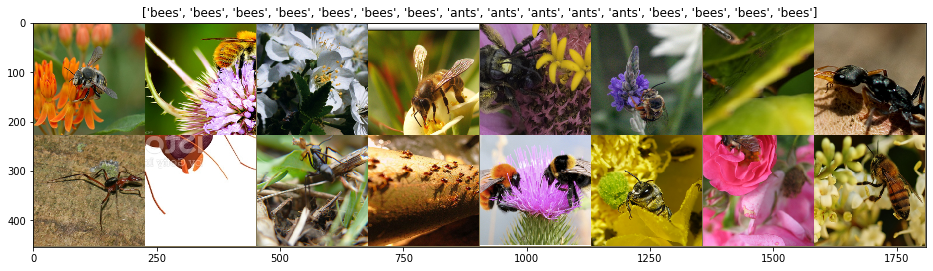

In [6]:
inputs, classes = next(iter(data_loaders['train']))
print(inputs.size())
grid = tv.utils.make_grid(inputs)
print(grid.size())
imshow(grid, title=[class_names[x] for x in classes])

## Training the model

- Scheduling the learning rate
- Saving the best model

In [ ]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=50):
    since = time.time()
    
    best_model_state = copy.deepcopy(model.state_dict())
    best_acc = 0.0